<a href="https://colab.research.google.com/github/Anagefilho/4imersao_dados_alura/blob/main/Base_cancer_mama_Gabriel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação das bibliotecas externas

In [ ]:
!pip install rampy
!pip install gcvspline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


http://charlesll.github.io/rampy/html/index.html
https://github.com/charlesll/rampy/tree/master/examples

# Importando bibliotecas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import rampy
import warnings as w

from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

# Funções que serão utilizadas.

In [ ]:
def load_ftir_data(filename):
    data = np.genfromtxt(filename)
    return data[:,:-1], data[:,-1].astype(int)
    
def sample_smoothing_differentiation_normalization(X):
    X_sav = savgol_filter(X, 25, 4, 2, axis=1)
    return X_sav / (np.linalg.norm(X_sav, 2, axis=1).reshape(-1, 1))

def sample_amida1_normalization(X, amida1_ids):
    return X / (np.max(X[:, amida1_ids], axis=1).reshape(-1, 1)) #Perguntar sobre o reshape 

def sample_train_test_LDA_SVM(X, y, training_method, C_Svm=None, gamma_SVM=None):
    #Treino e teste com LDA
    method = training_method
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1000)
    
    if method == 'LDA':
      m_conf = np.zeros((2,2))
      model = LinearDiscriminantAnalysis()

      for train_ids, test_ids in cv.split(X, y):
        model.fit(X[train_ids], y[train_ids])
        m_conf += confusion_matrix(y[test_ids], model.predict(X[test_ids]))
    
      print(m_conf)
      print("\n Matriz de confusão LDA")
      print("\n Acurácia: ",np.sum(np.diagonal(m_conf))/np.sum(m_conf))
      print("Sensibilidade: ",m_conf[1,1]/np.sum(m_conf[1]))
      print("Especificidade: ",m_conf[0,0]/np.sum(m_conf[0]))

    elif method == 'SVM':
      m_conf = np.zeros((2,2))

      model = svm.LinearSVC(C=C_Svm ,max_iter=10000, dual=False, random_state=1000)

      for train_ids, test_ids in cv.split(X, y):
        model.fit(X[train_ids], y[train_ids])
        m_conf += confusion_matrix(y[test_ids], model.predict(X[test_ids]))
      
      print(m_conf)
      print("\n\n Matriz de confusão SVM")
      print("\nAcurácia: ",np.sum(np.diagonal(m_conf))/np.sum(m_conf))
      print("Sensibilidade: ",m_conf[1,1]/np.sum(m_conf[1]))
      print("Especificidade: ",m_conf[0,0]/np.sum(m_conf[0]))
    
    elif method == 'SVM_gaussiano':
      m_conf = np.zeros((2,2))

      model = svm.NuSVC(gamma=gamma_SVM)

      for train_ids, test_ids in cv.split(X, y):
        model.fit(X[train_ids], y[train_ids])
        m_conf += confusion_matrix(y[test_ids], model.predict(X[test_ids]))
      
      print(m_conf)
      print("\n\n Matriz de confusão SVM Gaussiano")
      print("Acurácia: ",np.sum(np.diagonal(m_conf))/np.sum(m_conf))
      print("Sensibilidade: ",m_conf[1,1]/np.sum(m_conf[1]))
      print("Especificidade:", m_conf[0,0]/np.sum(m_conf[0]))

# Entrada dos dados

In [ ]:
#Caminho dos arquivos, necessário o upload no notebook para funcionar. 
wavsname="/content/wavenumbers_rob650.dat"
filename="/content/dataset_cancmama_bruto_v3.dat"

np.random.seed(1000) #Salvando o numero dessa seed, assim a iteração poderá ser replicada.

#load input data
X, y = load_ftir_data(filename)

#load wavs size
wavs = np.loadtxt(wavsname)

c1 = np.where(y == 1)[0] #Positivo
c2 = np.where(y == -1)[0]#Controle
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1000)

In [ ]:
#tentativa de equilibrar os dados, fazendo positivos ter 21 amostras e controle 22 mas não ajudou muito no resuultado.
X_eq = X[30:]
y_eq = y[30:]
X_eq.shape
c1_eq = np.where(y_eq == 1)[0] #Positivo
c2_eq = np.where(y_eq == -1)[0]#Controle


In [ ]:
X_raw_plot = X

In [ ]:
#Raw - Treino e teste
sel_wavs = np.where(np.logical_and(wavs >= 900, wavs <= 1800))[0] #Truncamento
X_raw = X[:,sel_wavs]

X_eq = X_raw[30:]
y_eq = y[30:]

sample_train_test_LDA_SVM(X_raw, y, 'LDA')
sample_train_test_LDA_SVM(X_raw, y,'SVM', 4096)
sample_train_test_LDA_SVM(X_raw, y,'SVM_gaussiano', None, 2**-19)

print("\n ----- X equilibrado 22 Pos, 21 Controle ------ / Raw ")

sample_train_test_LDA_SVM(X_eq, y_eq, 'LDA')
sample_train_test_LDA_SVM(X_eq, y_eq,'SVM',2048)
sample_train_test_LDA_SVM(X_eq, y_eq,'SVM_gaussiano',None,2**-19)

[[27. 39.]
 [55. 98.]]

 Matriz de confusão LDA

 Acurácia:  0.5707762557077626
Sensibilidade:  0.6405228758169934
Especificidade:  0.4090909090909091
[[ 22.  44.]
 [ 36. 117.]]


 Matriz de confusão SVM

Acurácia:  0.634703196347032
Sensibilidade:  0.7647058823529411
Especificidade:  0.3333333333333333
[[47. 19.]
 [91. 62.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.4977168949771689
Sensibilidade:  0.40522875816993464
Especificidade: 0.7121212121212122

 ----- X equilibrado 22 Pos, 21 Controle ------ / Raw 
[[22. 44.]
 [35. 28.]]

 Matriz de confusão LDA

 Acurácia:  0.3875968992248062
Sensibilidade:  0.4444444444444444
Especificidade:  0.3333333333333333
[[25. 41.]
 [40. 23.]]


 Matriz de confusão SVM

Acurácia:  0.37209302325581395
Sensibilidade:  0.36507936507936506
Especificidade:  0.3787878787878788
[[21. 45.]
 [30. 33.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.4186046511627907
Sensibilidade:  0.5238095238095238
Especificidade: 0.3181818181818182


In [ ]:
#Normalizacao pela amida 1 utilizando já a função feita pelo Murillo
amida1_ids = np.where(np.logical_and(wavs>=1630, wavs<=1660))[0] 
X = sample_amida1_normalization(X, amida1_ids)

#Truncamento (900-1800cm-1)
#sel_wavs = np.where(np.logical_and(wavs >= 900, wavs <= 1800))[0]
#X = X[:,sel_wavs]

# Pré processamento

In [ ]:
#Pré-processamento utilizando o Rampy.

"""Acontecendo muito o warning de: 
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) ), ArPLS está gerando este aviso"""

roi = np.array([[900,1800], [2800, 3050]])

poly = np.zeros((X.shape))
gcvspl = np.zeros((X.shape))
uni = np.zeros((X.shape))
als = np.zeros((X.shape))
arpls = np.zeros((X.shape))
drpls = np.zeros((X.shape))
rubberband = np.zeros((X.shape))

# calculating the baselines
for i in range(0, X.shape[0]):
  ycalc_poly, base_poly = rampy.baseline(wavs, X[i], roi,'poly', polynomial_order=4) #ir de 1 em 1 e salvar essa base de dados nova ja processada.
  ycalc_gcvspl, base_gcvspl = rampy.baseline(wavs,X[i],roi,'gcvspline',s=0.1 ) 
  ycalc_uni, base_uni = rampy.baseline(wavs, X[i], roi, 'unispline', s=1e0)
  ycalc_als, base_als = rampy.baseline(wavs, X[i], roi, 'als', lam=10**5, p=0.05)
 
  ycalc_arpls, base_arpsl = rampy.baseline(wavs, X[i], roi, 'arPLS', lam=10**5, ratio=0.01)
  ycalc_drpls, base_drpsl = rampy.baseline(wavs, X[i], roi, 'drPLS')
  ycalc_rubberband, base_rubberband = rampy.baseline(wavs, X[i], roi, 'rubberband')

  poly[i] = ycalc_poly.reshape(-1)
  gcvspl[i] = ycalc_gcvspl.reshape(-1)
  uni[i] = ycalc_uni.reshape(-1)
  als[i] = ycalc_als.reshape(-1)
  arpls[i] = ycalc_arpls.reshape(-1)
  drpls[i] = ycalc_drpls.reshape(-1)
  rubberband[i] = ycalc_rubberband.reshape(-1)

/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/usr/local/lib/python3.7/dist-packages/rampy/baseline.py:243: RuntimeWarning: overflow encount

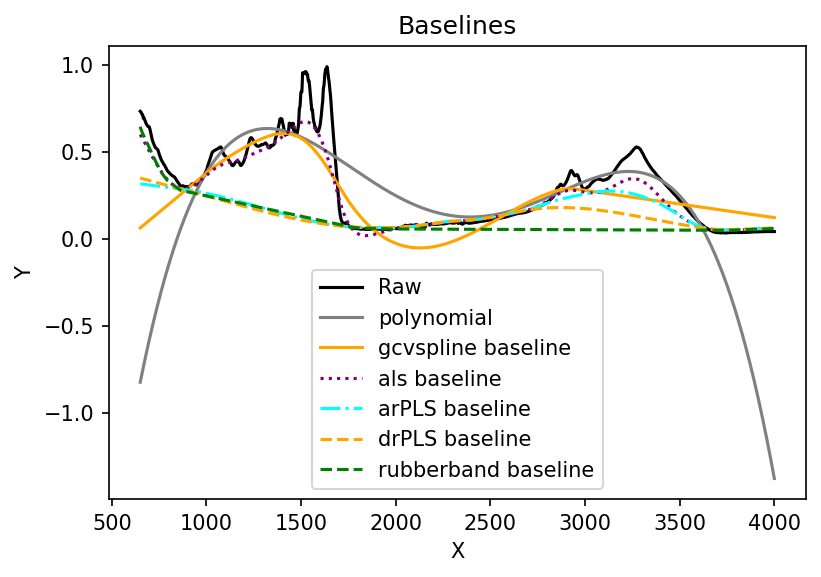

In [ ]:
# doing the figure
plt.figure(dpi=150)
plt.plot(wavs, np.mean(X, axis=0), "k-", label="Raw")

plt.plot(wavs, base_poly, "-", color="grey", label="polynomial")
#plt.plot(wavs, base_uni, "b-", label="unispline baseline")# Gráfico não funciona quando plota o uni...
plt.plot(wavs, base_gcvspl,"-",color="orange",label="gcvspline baseline") 
plt.plot(wavs, base_als, ":", color="purple", label="als baseline")
plt.plot(wavs, base_arpsl, "-.", color="cyan", label="arPLS baseline")
plt.plot(wavs, base_drpsl, "--", color="orange", label="drPLS baseline")
plt.plot(wavs, base_rubberband, "--", color="green", label="rubberband baseline")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Baselines")

plt.legend()

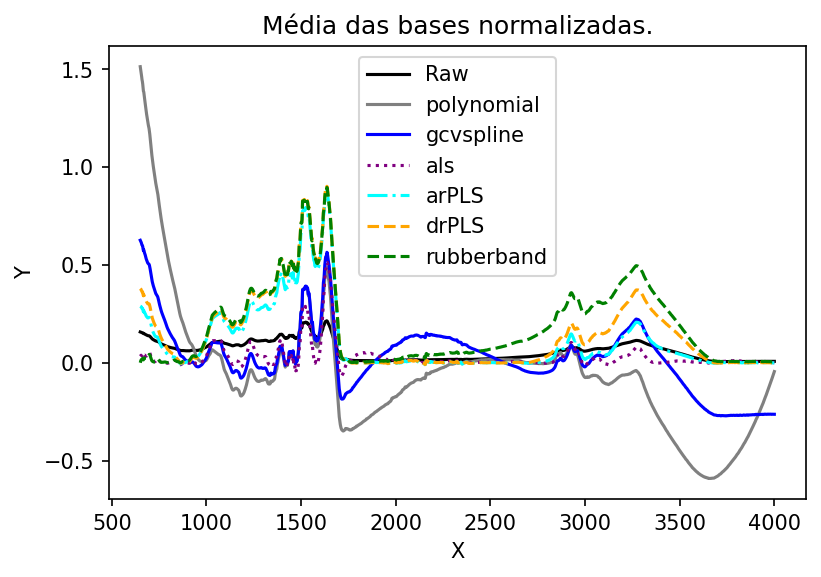

In [ ]:
# doing the figure
plt.figure(dpi=150)
plt.plot(wavs, np.mean(X_raw_plot, axis=0),  "k-", label="Raw")

plt.plot(wavs, np.mean(poly, axis=0), "-", color="grey", label="polynomial")
plt.plot(wavs, np.mean(gcvspl, axis=0), "-", color="b", label="gcvspline")
#plt.plot(wavs, np.mean(uni, axis=0), "-", color="b", label="gcvspline")
plt.plot(wavs, np.mean(als, axis=0), ":", color="purple", label="als")
plt.plot(wavs, np.mean(arpls, axis=0), "-.", color="cyan", label="arPLS")
plt.plot(wavs, np.mean(drpls, axis=0), "--", color="orange", label="drPLS")
plt.plot(wavs, np.mean(rubberband, axis=0), "--", color="green", label="rubberband")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Média das bases normalizadas.")

plt.legend()

In [ ]:
#Conecta o google drive e faz backup dentro dele.
np.savetxt("/content/drive/MyDrive/poly_database_Cancmama.dat",poly)
np.savetxt("/content/drive/MyDrive/gcvspl_database_Cancmama.dat",gcvspl)
np.savetxt("/content/drive/MyDrive/uni_database_Cancmama.dat",uni)
np.savetxt("/content/drive/MyDrive/als_database_Cancmama.dat",als)
np.savetxt("/content/drive/MyDrive/arpls_database_Cancmama.dat",arpls)
np.savetxt("/content/drive/MyDrive/drpls_database_Cancmama.dat",drpls)
np.savetxt("/content/drive/MyDrive/rubberband_database_Cancmama.dat",rubberband)

# Treino e teste

In [ ]:
#Validação cruzada com 5 pastas (3 repetições)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1000)

methods = [poly, gcvspl, uni, als, arpls, drpls,rubberband]
matrizes = ['Poly', 'Gcvspline', 'Unispline', 'Als', 'Arpls','Drpls','Rubberband']
c = 0

for i in methods:
  print("\nMétodo: ",matrizes[c])
  sample_train_test_LDA_SVM(i, y, 'LDA')
  sample_train_test_LDA_SVM(i, y,'SVM', 8192)
  sample_train_test_LDA_SVM(i, y,'SVM_gaussiano',None,2**-19)
  print("---------------------------------")
  c+=1


Método:  Poly
[[ 21.  45.]
 [ 50. 103.]]

 Matriz de confusão LDA

 Acurácia:  0.5662100456621004
Sensibilidade:  0.673202614379085
Especificidade:  0.3181818181818182
[[ 21.  45.]
 [ 40. 113.]]


 Matriz de confusão SVM

Acurácia:  0.6118721461187214
Sensibilidade:  0.738562091503268
Especificidade:  0.3181818181818182
[[35. 31.]
 [75. 78.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.5159817351598174
Sensibilidade:  0.5098039215686274
Especificidade: 0.5303030303030303
---------------------------------

Método:  Gcvspline
[[ 19.  47.]
 [ 49. 104.]]

 Matriz de confusão LDA

 Acurácia:  0.5616438356164384
Sensibilidade:  0.6797385620915033
Especificidade:  0.2878787878787879
[[ 24.  42.]
 [ 42. 111.]]


 Matriz de confusão SVM

Acurácia:  0.6164383561643836
Sensibilidade:  0.7254901960784313
Especificidade:  0.36363636363636365
[[35. 31.]
 [82. 71.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.4840182648401826
Sensibilidade:  0.46405228758169936
Especificidade: 0.5303030303

In [ ]:
#Sav golav
X = sample_smoothing_differentiation_normalization(X)

sample_train_test_LDA_SVM(X, y, 'LDA')
sample_train_test_LDA_SVM(X, y, 'SVM', 8128)

[[ 18.  48.]
 [ 41. 112.]]

 Matriz de confusão LDA

 Acurácia:  0.593607305936073
Sensibilidade:  0.7320261437908496
Especificidade:  0.2727272727272727
[[ 19.  47.]
 [ 44. 109.]]


 Matriz de confusão SVM

Acurácia:  0.5844748858447488
Sensibilidade:  0.7124183006535948
Especificidade:  0.2878787878787879


In [ ]:
sample_train_test_LDA_SVM(X, y, 'SVM_gaussiano', None, 2**-15)

[[ 38.  28.]
 [101.  52.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.410958904109589
Sensibilidade:  0.33986928104575165
Especificidade: 0.5757575757575758


In [ ]:
sample_train_test_LDA_SVM(X, y, 'SVM_gaussiano', None, 'auto')

[[31. 35.]
 [78. 75.]]


 Matriz de confusão SVM Gaussiano
Acurácia:  0.4840182648401826
Sensibilidade:  0.49019607843137253
Especificidade: 0.4696969696969697


In [ ]:
#Treino e teste com SVM
clf = svm.LinearSVC(C=1,max_iter=10000, dual=False, random_state=1000)
clf_16 = svm.LinearSVC(C=16,max_iter=10000, dual=False, random_state=1000)
clf_64 = svm.LinearSVC(C=64,max_iter=10000, dual=False, random_state=1000)
clf_128 = svm.LinearSVC(C=8192,max_iter=10000, dual=False, random_state=1000)

m_conf = np.zeros((2,2))
m_conf_16 = np.zeros((2,2))
m_conf_64 = np.zeros((2,2))
m_conf_128 = np.zeros((2,2))

for train_ids, test_ids in cv.split(X, y):
  clf.fit(X[train_ids], y[train_ids])
  clf_16.fit(X[train_ids], y[train_ids])
  clf_64.fit(X[train_ids], y[train_ids])
  clf_128.fit(X[train_ids], y[train_ids])
  
  m_conf += confusion_matrix(y[test_ids], clf.predict(X[test_ids]))
  m_conf_16 += confusion_matrix(y[test_ids], clf_16.predict(X[test_ids]))
  m_conf_64 += confusion_matrix(y[test_ids], clf_64.predict(X[test_ids]))
  m_conf_128 += confusion_matrix(y[test_ids], clf_128.predict(X[test_ids]))

print("\n Matriz de confusão C = 1")
print(m_conf)
print("\n Acurácia: ",np.sum(np.diagonal(m_conf))/np.sum(m_conf))
print("Sensibilidade: ",m_conf[1,1]/np.sum(m_conf[1]))
print("Especificidade: ",m_conf[0,0]/np.sum(m_conf[0]))

print("\n Matriz de confusão C = 16 ")
print(m_conf_16)
print("\n Acurácia: ",np.sum(np.diagonal(m_conf_16))/np.sum(m_conf_16))
print("Sensibilidade: ",m_conf_16[1,1]/np.sum(m_conf_16[1]))
print("Especificidade: ",m_conf_16[0,0]/np.sum(m_conf_16[0]))

print("\n Matriz de confusão C = 64\n")
print(m_conf_64)
print("\n Acurácia: ",np.sum(np.diagonal(m_conf_64))/np.sum(m_conf_64))
print("Sensibilidade: ",m_conf_64[1,1]/np.sum(m_conf_64[1]))
print("Especificidade: ",m_conf_64[0,0]/np.sum(m_conf_64[0]))

print("\n Matriz de confusão C = 128 \n")
print(m_conf_128)
print("\n Acurácia: ",np.sum(np.diagonal(m_conf_128))/np.sum(m_conf_128))
print("Sensibilidade: ",m_conf_128[1,1]/np.sum(m_conf_128[1]))
print("Especificidade: ",m_conf_128[0,0]/np.sum(m_conf_128[0]))


 Matriz de confusão C = 1
[[  1.  65.]
 [  4. 149.]]

 Acurácia:  0.684931506849315
Sensibilidade:  0.9738562091503268
Especificidade:  0.015151515151515152

 Matriz de confusão C = 16 
[[ 15.  51.]
 [ 25. 128.]]

 Acurácia:  0.6529680365296804
Sensibilidade:  0.8366013071895425
Especificidade:  0.22727272727272727

 Matriz de confusão C = 64

[[ 15.  51.]
 [ 34. 119.]]

 Acurácia:  0.6118721461187214
Sensibilidade:  0.7777777777777778
Especificidade:  0.22727272727272727

 Matriz de confusão C = 128 

[[ 20.  46.]
 [ 41. 112.]]

 Acurácia:  0.6027397260273972
Sensibilidade:  0.7320261437908496
Especificidade:  0.30303030303030304
